<a href="https://colab.research.google.com/github/ayushmangupta/DataScience/blob/master/TrainingBoardDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import cv2
from joblib import Parallel, delayed
import multiprocessing
import random
from tqdm import tqdm_notebook
import numpy as np
#from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import skimage
import tensorflow.keras.layers as tfkl
import tensorflow.keras as tfk
#!pip install tensorflow-gpu==2.0.0-beta1
import tensorflow as tf
import imageio
import imgaug as ia
from imgaug import augmenters as iaa
import h5py
from tensorflow.keras.models import load_model
print(tf.__version__)
print(tf.test.is_gpu_available())




1.14.0-rc1
True


In [2]:


from google.colab import files
uploaded = files.upload()

Saving disk2.jpg to disk2.jpg
Saving disk1.jpeg to disk1.jpeg
Saving disk0.jpeg to disk0.jpeg


In [3]:
batch =100
white = cv2.imread("disk0.jpeg")
black = cv2.imread("disk1.jpeg")
blank = cv2.imread("disk2.jpg")
from skimage.transform import resize
w_r= resize(white, (100, 100), anti_aliasing=True)
b_r= resize(black, (100, 100), anti_aliasing=True)
blank_r= resize(blank, (100, 100), anti_aliasing=True)
from tensorflow.keras.models import load_model
disks = [w_r,b_r,blank_r]
disks_array = [0,1,2]

def aug(img):
    bblur =iaa.GaussianBlur(sigma=(0,np.random.randint(2)))
    img= bblur.augment_image(img)
    noise = iaa.AdditiveGaussianNoise(loc=0.0,scale=np.random.choice([.01,.02,.03,.04,0.05,0.06,0.07,0.08,0.09]))
    img = noise.augment_image(img.astype(np.float32))
    pad = iaa.Pad(keep_size=True,px=(np.random.randint(4,15),np.random.randint(4,15),np.random.randint(4,15),np.random.randint(4,15)))
    img =  pad.augment_image(img)
    image_rotate = iaa.Affine(rotate=(np.random.randint(-12,12),np.random.randint(-10,10)))
    image_ = image_rotate.augment_image(img)
    img = img.astype(np.float64)
    return image_
#plot(aug(img))

def create_board():
    #np.random.seed(seed=1)
    #starter = np.vstack([disks[np.random.choice([0,1,2])] for x in range(8)])
    starter_array = np.vstack([disks_array[np.random.choice([0,1,2])] for x in range(8)])
    #main_b = np.array([])
    for i in range(7):
        #starter = np.hstack([starter,np.vstack([disks[np.random.choice([0,1,2])] for x in range(8)])])
        starter_array = np.hstack([starter_array,np.vstack([disks_array[np.random.choice([0,1,2])] for x in range(8)])])
        
    #print(starter_array)
    return starter_array
  
  
def create_board_image(arr):
    x = np.vstack([np.hstack([disks[j] for j in i]) for i in arr] )
    return resize(x, (224,224), anti_aliasing=True)
  
def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

data_img = []
data_y = []
for d in tqdm_notebook(range(batch)):
    arr =  create_board()
    img = create_board_image(arr)
    y = arr.flatten()
    y = one_hot(y,3).flatten()
    
    data_img.append(img)
    data_y.append(y)
    
data_img = np.reshape(data_img,[batch,224,224,3])
data_img = np.array(data_img)
for ix in range(len(data_img)):
    data_img[ix] = aug(data_img[ix]) 

data_y = np.array(data_y)

In [6]:
!ls

disk0.jpeg  disk1.jpeg	disk2.jpg  sample_data


In [0]:
#loded_model = load_model("")

In [9]:

model = tfk.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 7s 0us/step


In [10]:
y = model.output
print(y.shape)
y = tfkl.Flatten()(y)
y = tfkl.Dense(192, activation='sigmoid', name='class_id')(y)

W0622 08:30:37.301754 140658314274688 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


(?, 7, 7, 2048)


In [0]:
#print(data_img.shape,data_y.shape)

In [0]:
# for ix in range(1):
#   plot(np.squeeze(data_img[ix+6],2))
#   print(data_y[ix+6])

In [0]:
opt = tf.keras.optimizers.RMSprop(lr = 0.001)

In [0]:
new_model = tfk.Model(inputs=model.input, outputs=y)

In [13]:
new_model.compile(loss='binary_crossentropy',
            optimizer=opt,
              metrics=['accuracy'])

W0622 08:30:37.705047 140658314274688 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
#new_model.summary()

In [1]:
!ls

sample_data


In [4]:
#from google.colab import drive
#drive.mount('/content/gdrive')
path = F"/content/gdrive/My Drive/boardmodelResnet.h5" 
model = load_model(path)

# filepath="weights-board-{epoch:02d}-{val_acc:.2f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]
model.fit(x=data_img, y=data_y, validation_split=0.1, epochs=2, batch_size=15, verbose=2)

W0622 09:44:36.857670 139631973070720 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 90 samples, validate on 10 samples
Epoch 1/2
90/90 - 11s - loss: 9.8432e-04 - acc: 0.9997 - val_loss: 0.0728 - val_acc: 0.9870
Epoch 2/2
90/90 - 1s - loss: 8.1883e-04 - acc: 0.9997 - val_loss: 0.0165 - val_acc: 0.9948


In [0]:
model.save("boardmodelResnet.h5")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls /content/gdrive/My\ Drive

In [0]:
new_model.save(path)

In [0]:
model.predict()

In [0]:
prediction = model.predict(data_img)
pred = prediction[1]

In [0]:
img = data_img[1]

W0622 09:16:14.525697 140468909094784 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


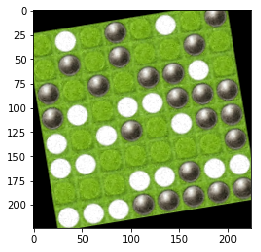

In [13]:
plt.imshow(img)

In [0]:
a = prediction[1]
a = a.reshape([64,3])
a = np.round(a)
b=np.array([np.where(r==1)[0][0] for r in a])
b = b.reshape([8,8])

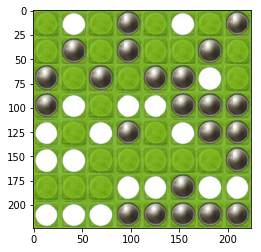

In [21]:
plt.imshow(create_board_image(b))

ValueError: ignored

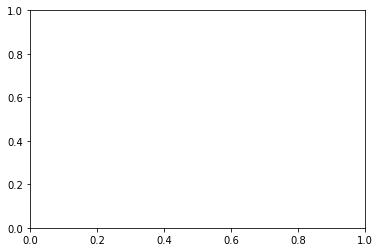

In [0]:
plt.plot(data_img)

array([[0, 2, 0, 0, 2, 2, 0, 1],
       [2, 2, 2, 2, 0, 0, 0, 1],
       [2, 1, 0, 1, 1, 0, 0, 0],
       [2, 1, 2, 1, 2, 1, 1, 1],
       [1, 1, 0, 0, 2, 1, 0, 2],
       [0, 0, 0, 0, 0, 1, 2, 1],
       [0, 0, 0, 1, 1, 1, 0, 2],
       [2, 0, 0, 0, 2, 1, 2, 0]])